In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input, Reshape
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
import numpy as np
import pandas as pd
from sklearn import preprocessing 
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
!pip install numpy requests nlpaug
import pandas as pd
import numpy as np
import nlpaug.augmenter.word as nlpaw
from tqdm import tqdm

     |████████████████████████████████| 405 kB 596 kB/s eta 0:00:01


In [3]:
def dataframe_creation():
    col_list=['Loc','Pred','Sent','Topic','Speaker','Position','Region','Party','a','b','c','d','e','Occasion']
    df_4 = pd.read_csv('../input/newsdatasets/other_dataset/other_dataset/LIAR/valid.tsv',header = None,sep='\t')
    df_4.columns =  col_list
    return df_4

df = dataframe_creation()
print(df.shape)
le = preprocessing.LabelEncoder()
df.head()

(12791, 14)


,Loc,Pred,Sent,Topic,Speaker,Position,Region,Party,a,b,c,d,e,Occasion
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30.0,30.0,42.0,23.0,18.0,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2.0,1.0,0.0,0.0,0.0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63.0,114.0,51.0,37.0,61.0,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1.0,1.0,3.0,1.0,1.0,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5.0,7.0,2.0,2.0,7.0,a web video


In [5]:
df.columns

Index(['Loc', 'Pred', 'Sent', 'Topic', 'Speaker', 'Position', 'Region',
       'Party', 'a', 'b', 'c', 'd', 'e', 'Occasion'],
      dtype='object')

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X = df['Sent']
Y = df['Pred']
def maxlength(lt):
    maxi = 0
    for i in lt:
        maxi  = max(maxi, len(str(i).split()) )
    return maxi
max_len= maxlength(X)

In [33]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
balanced_df = df.groupby('Pred').apply(lambda x: x.sample(894)).reset_index(drop=True)
balanced_df['Sent'] = balanced_df['Sent'].astype(str)

In [34]:
balanced_df.groupby('Pred').count()

,Loc,Sent,Topic,Speaker,Position,Region,Party,a,b,c,d,e,Occasion
Pred,,,,,,,,,,,,,
barely-true,894,894,894,894,632,708,894,894,894,894,894,894,888
false,894,894,894,894,636,695,894,894,894,894,894,894,886
half-true,894,894,894,894,664,712,894,894,894,894,894,894,887
mostly-true,894,894,894,894,670,739,894,894,894,894,894,894,882
pants-fire,894,894,894,894,531,552,894,894,894,894,894,894,880
true,894,894,894,894,692,731,894,894,894,894,894,894,884


In [35]:
balanced_df.head()

,Loc,Pred,Sent,Topic,Speaker,Position,Region,Party,a,b,c,d,e,Occasion
0,5332.json,barely-true,Says Gov. Bob McDonnells budget would cut pre-...,"education,state-budget",george-barker,State senator,Virginia,democrat,1.0,0.0,0.0,0.0,0.0,a speech.
1,9394.json,barely-true,Says Barack Obama broke a decades-old policy o...,"foreign-policy,iraq,terrorism",ted-cruz,Senator,Texas,republican,36.0,33.0,15.0,19.0,8.0,"comments on ABC's ""This Week"""
2,4207.json,barely-true,Social Security doesnt contribute a penny to t...,"deficit,federal-budget,social-security",alliance-retired-americans,NaN,"Washington, D.C.",organization,1.0,0.0,0.0,0.0,0.0,an email blast
3,3854.json,barely-true,Planned Parenthood raked in more than $300 mil...,abortion,marjorie-dannenfelser,NaN,NaN,newsmaker,1.0,0.0,0.0,0.0,0.0,a blog
4,693.json,barely-true,"For four days in Denver, the Democrats were af...",terrorism,rudy-giuliani,Attorney,New York,republican,9.0,11.0,10.0,7.0,3.0,a speech at the Republican National Convention.


In [36]:
balanced_df.shape

(5364, 14)

In [37]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
from nltk.tokenize import word_tokenize
def filter(lt):
    nlt=[]
    i = 0
    for text in tqdm(lt):
        text = str(text)
        text_tokens = word_tokenize(text)
        tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
        filtered_sentence = (" ").join(tokens_without_sw)
        nlt.append(filtered_sentence)
    return nlt

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
X = balanced_df['Sent']
Y = balanced_df['Pred']
X_f = filter(X)
max_len= maxlength(X_f)

In [ ]:
df = pd.DataFrame(list(zip(X,Y)),
               columns =['Sent', 'Pred'])
df.to_csv('Liar_Preprocessed.csv',index=False)
df = df.sample(frac=1)
print(df.shape)
df.head()

In [38]:
X = df['Sent']
Y = df['Pred']
max_len= maxlength(X)
le.fit(Y)
Y = le.transform(Y)
num_classes=  len(le.classes_)
num_classes

6

In [9]:
def Convert(lst):
    res_dct = {i : lst[i] for i in range(0, len(lst))}
    return res_dct
classes = Convert(le.classes_)

# Transfer Learning

In [10]:
from tqdm.notebook import tqdm
from transformers import BertTokenizer, TFBertModel, TFDistilBertModel,DistilBertTokenizer , RobertaTokenizer, TFRobertaModel
#dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
#robert_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
#robert_model = TFRobertaModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [11]:
def data_creation(X,Y,token):
    input_ids=[]
    attention_masks=[]
    for sent in tqdm(X):
        dbert_inps=token.encode_plus(str(sent),add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
        input_ids.append(dbert_inps['input_ids'])
        attention_masks.append(dbert_inps['attention_mask'])

    input_ids=np.asarray(input_ids)
    attention_masks=np.array(attention_masks)
    Y=np.array(Y)
    print(len(input_ids),len(attention_masks),len(Y))
    return input_ids,attention_masks,Y

In [12]:
model_use = bert_model
token_use = bert_tokenizer
input_ids,attention_masks,Y = data_creation(X,Y,token_use)

  0%|          | 0/10675 [00:00<?, ?it/s]

10675 10675 10675


In [13]:
from tensorflow.keras.layers import LSTM,add
from tensorflow.keras.layers import Flatten , Conv1D
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten , Conv1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,MaxPooling1D
from tensorflow.keras.utils import plot_model
def create_model(max_len,num_classes,mod):
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    dbert_layer = mod(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(4096,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dbert_layer)
    dense = Reshape(( 256 , 16))(dense)
    head4 = Conv1D(36,5)(dense)
    head4 = MaxPooling1D(5,padding='same')(head4)
    head4 = Flatten()(head4)
    dropout= Dropout(0.5)(head4)
    pred = Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    return model

In [14]:
model = create_model(max_len,num_classes,model_use)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_bert_model[0][0]          

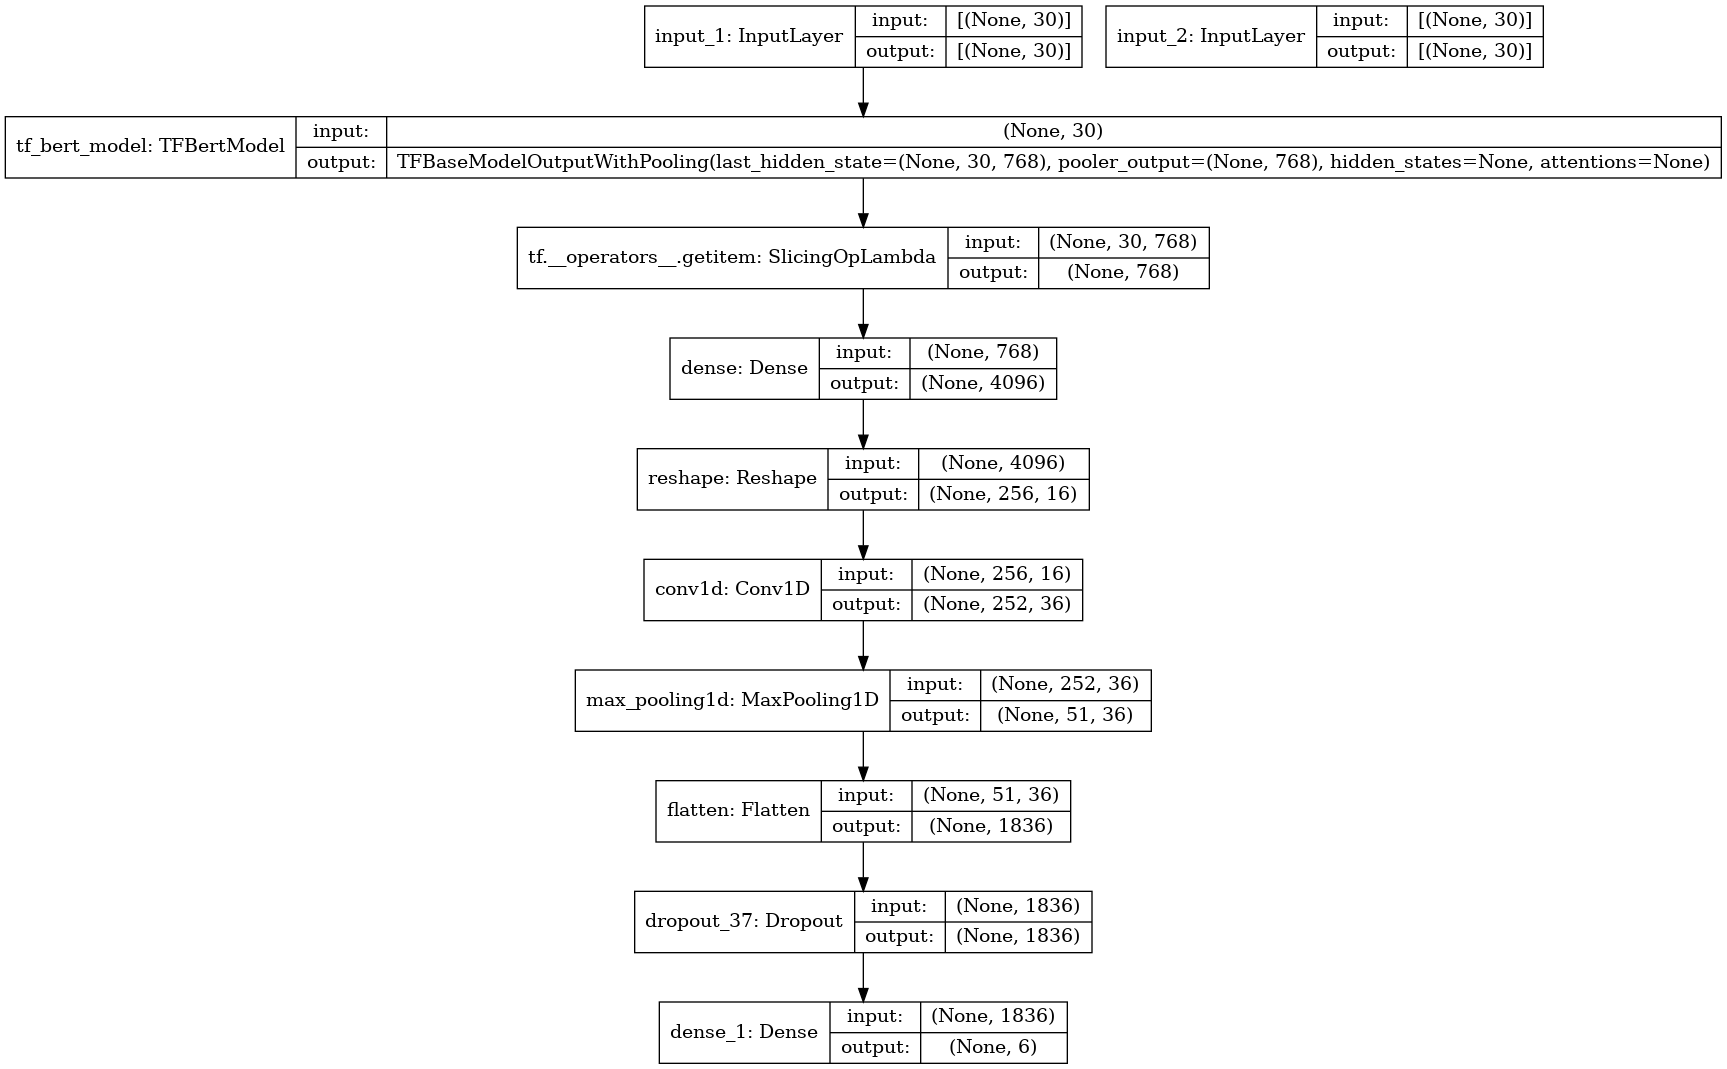

In [15]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

In [16]:
print('Preparing the pickle file.....')

pickle_inp_path='dbert_inp.pkl'
pickle_mask_path='dbert_mask.pkl'
pickle_Pred_path='dbert_Pred.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((Y),open(pickle_Pred_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_Pred_path)

Preparing the pickle file.....
Pickle files saved as  dbert_inp.pkl dbert_mask.pkl dbert_Pred.pkl


In [17]:
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
Preds=pickle.load(open(pickle_Pred_path, 'rb'))

print('Input shape {} Attention mask shape {} Input Pred shape {}'.format(input_ids.shape,attention_masks.shape,Preds.shape))

Loading the saved pickle files..
Input shape (10675, 30) Attention mask shape (10675, 30) Input Pred shape (10675,)


In [18]:
classes

{0: 'barely-true',
 1: 'false',
 2: 'half-true',
 3: 'mostly-true',
 4: 'pants-fire',
 5: 'true'}

In [19]:
Pred_class_dict=classes
target_names=Pred_class_dict.values()

In [20]:
train_inp,val_inp,train_Pred,val_Pred,train_mask,val_mask=train_test_split(input_ids,Preds,attention_masks,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain Pred shape {} Val Pred shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_Pred.shape,val_Pred.shape,train_mask.shape,val_mask.shape))


log_dir='dbert_model'
model_save_path='./dbert_model.h5'

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

Train inp shape (8540, 30) Val input shape (2135, 30)
Train Pred shape (8540,) Val Pred shape (2135,)
Train attention mask shape (8540, 30) Val attention mask shape (2135, 30)


In [21]:
history=model.fit([input_ids,attention_masks],Preds,batch_size=64,epochs=10,validation_data=([val_inp,val_mask],val_Pred))

Epoch 1/10
167/167 [==============================] - 67s 372ms/step - loss: 14.0454 - accuracy: 0.2086 - val_loss: 11.6833 - val_accuracy: 0.2749
Epoch 2/10
167/167 [==============================] - 62s 373ms/step - loss: 11.0462 - accuracy: 0.2548 - val_loss: 9.1676 - val_accuracy: 0.3475
Epoch 3/10
167/167 [==============================] - 62s 369ms/step - loss: 8.6956 - accuracy: 0.3396 - val_loss: 7.1536 - val_accuracy: 0.5213
Epoch 4/10
167/167 [==============================] - 62s 371ms/step - loss: 6.8442 - accuracy: 0.4498 - val_loss: 5.4916 - val_accuracy: 0.7101
Epoch 5/10
167/167 [==============================] - 62s 371ms/step - loss: 5.3347 - accuracy: 0.6082 - val_loss: 4.2385 - val_accuracy: 0.8033
Epoch 6/10
167/167 [==============================] - 61s 368ms/step - loss: 4.1722 - accuracy: 0.7300 - val_loss: 3.3241 - val_accuracy: 0.8567
Epoch 7/10
167/167 [==============================] - 62s 374ms/step - loss: 3.2575 - accuracy: 0.8246 - val_loss: 2.5908 - val

## Evaluation

In [22]:
preds = model.predict([val_inp,val_mask],batch_size=16)
pred_Preds = preds.argmax(axis=1)
target_names=le.classes_
print('Classification Report')
print(classification_report(val_Pred,pred_Preds,target_names=target_names))
print('Training and saving built model.....')

Classification Report
              precision    recall  f1-score   support

 barely-true       0.99      0.97      0.98       359
       false       1.00      0.99      0.99       409
   half-true       0.97      0.98      0.98       416
 mostly-true       0.99      0.98      0.98       408
  pants-fire       0.98      0.99      0.99       178
        true       0.98      0.99      0.99       365

    accuracy                           0.98      2135
   macro avg       0.98      0.99      0.98      2135
weighted avg       0.98      0.98      0.98      2135

Training and saving built model.....


# Create Test from test data and remove non corpus words

In [23]:
col_list=['Loc','Pred','Sent','Topic','Speaker','Position','Region','Party','a','b','c','d','e','Occasion']
dfT = pd.read_csv('../input/newsdatasets/other_dataset/other_dataset/LIAR/test.tsv',header = None,sep='\t')
dfT.columns =  col_list
dfT.head()

,Loc,Pred,Sent,Topic,Speaker,Position,Region,Party,a,b,c,d,e,Occasion
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [25]:
Xt = dfT['Sent']
Yt = dfT['Pred']
Yt = le.transform(Yt)

In [27]:
input_idsT,attention_masksT,YT = data_creation(Xt,Yt,token_use)

  0%|          | 0/1057 [00:00<?, ?it/s]

1057 1057 1057


In [30]:
preds = model.predict([input_idsT,attention_masksT],batch_size=16)
pred_Preds = preds.argmax(axis=1)
target_names=le.classes_
#$print('F1 score',f1)
print('Classification Report')
print(classification_report(Yt,pred_Preds,target_names=target_names))
print('Training and saving built model.....')

Classification Report
              precision    recall  f1-score   support

 barely-true       0.99      0.98      0.99       177
       false       0.99      1.00      0.99       221
   half-true       1.00      0.99      0.99       216
 mostly-true       0.99      0.99      0.99       192
  pants-fire       0.96      1.00      0.98        72
        true       0.99      1.00      0.99       179

    accuracy                           0.99      1057
   macro avg       0.99      0.99      0.99      1057
weighted avg       0.99      0.99      0.99      1057

Training and saving built model.....
